# Using openwatcherhub for local SentinelHub processing

The purpose of this notebook is to demonstrate how easy it is to migrate your workflow from accessing the data through the Copernicus Open Access Hub to using APIs to access the data via the Copernicus Data Space Ecosystem. In this notebook, we will show you how to:
- setup your credentials
- search, discover and download Sentinel-2 L2A Granules using Open Data Protocol (OData)
- search, discover and download Sentinel-2 L2A data using Sentinel Hub APIs via openwatcherhub deployed locally.

In [1]:
!pip install sentinelhub eo-learn

First we need to import some prerequisite libraries: 

In [2]:
# Utilities
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)
from typing import Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np


def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

# Patch sentinelhub session to not handle oauth2
from sentinelhub.download.session import SentinelHubSession
SentinelHubSession._collect_new_token = lambda self: {'access_token': "herp", "expires_at": 0}

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

To search the catalogue we use the following code block:

## Accessing data via Sentinel Hub APIs

The [Sentinel Hub API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub.html) is a RESTful API interface that provides access to various satellite imagery archives. It allows you to access raw satellite data, [rendered images](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html), [statistical analysis](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html), and other features. 

In these examples, we will be using the `sentinelhub` python [package](https://sentinelhub-py.readthedocs.io/en/latest/index.html). The sentinelhub Python package is the official Python interface for [Sentinel Hub](https://www.sentinel-hub.com/) services. The package provides a collection of basic tools and utilities for working with geospatial and satellite data. It builds on top of well known packages such as `numpy`, `shapely`, `pyproj`.

To successfully run this notebook, make sure that you install or upgrade to at least Version `3.9.1`.

In [3]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = "HERPDERP"
config.sh_client_secret = "DERPHERP"
config.sh_token_url = ""
config.sh_base_url = "http://192.168.1.101:8081"

### Setting an area of interest

The bounding box in `WGS84` coordinate system is `[(longitude and latitude coordinates of lower left and upper right corners)]`. You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

All requests require a bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). In our case it is in WGS84 and we can use the predefined WGS84 coordinate reference system from `sentinelhub.constants.CRS`.

In [4]:
aoi_coords_wgs84 = [-122.310791,37.378342,-122.076988,37.515717]

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [5]:
resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 10 m resolution: (2055, 1542) pixels


### Process API

#### Example 1: True Color Image

We build the request according to the [API Reference](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and it’s size (size or resolution).
- `mosaickingOrder` (optional): in this example we have used `leastCC` which will return pixels from the least cloudy acquisition in the specified time period.

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L2A bands.

The least cloudy image from the time period is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in `UINT8` format (values in 0-255 range).

In [6]:
evalscript_true_color = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B03", "B02"],
    output: { bands: 3 }
  };
}

// Contrast enhance / highlight compress


const maxR = 3.0; // max reflectance

const midR = 0.13;
const sat = 1.2;
const gamma = 1.8;



function sAdj(a) {
  return adjGamma(adj(a, midR, 1, maxR));
}

const gOff = 0.01;
const gOffPow = Math.pow(gOff, gamma);
const gOffRange = Math.pow(1 + gOff, gamma) - gOffPow;

function adjGamma(b) {
  return (Math.pow((b + gOff), gamma) - gOffPow) / gOffRange;
}

// Saturation enhancement

function satEnh(r, g, b) {
  const avgS = (r + g + b) / 3.0 * (1 - sat);
  return [clip(avgS + r * sat), clip(avgS + g * sat), clip(avgS + b * sat)];
}

function clip(s) {
  return s < 0 ? 0 : s > 1 ? 1 : s;
}

//contrast enhancement with highlight compression

function adj(a, tx, ty, maxC) {
  var ar = clip(a / maxC);
  return ar * (ar * (tx / maxC + ty - 1) - ty) / (ar * (2 * tx / maxC - 1) - tx / maxC);
}

function sRGB(c) {
    return c <= 0.0031308 ? (12.92 * c) : (1.055 * Math.pow(c, 0.41666666666) - 0.055);
}

function evaluatePixel(smp) {
  const rgbLin = satEnh(sAdj(smp.B04), sAdj(smp.B03), sAdj(smp.B02));
  return [sRGB(rgbLin[0]), sRGB(rgbLin[1]), sRGB(rgbLin[2])];
}
"""



request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="http://192.168.1.101:8081"
            ),
            time_interval=("2023-07-01", "2023-07-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [7]:
true_color_imgs = request_true_color.get_data()

In [8]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1542, 2055, 3)


Image type: uint8


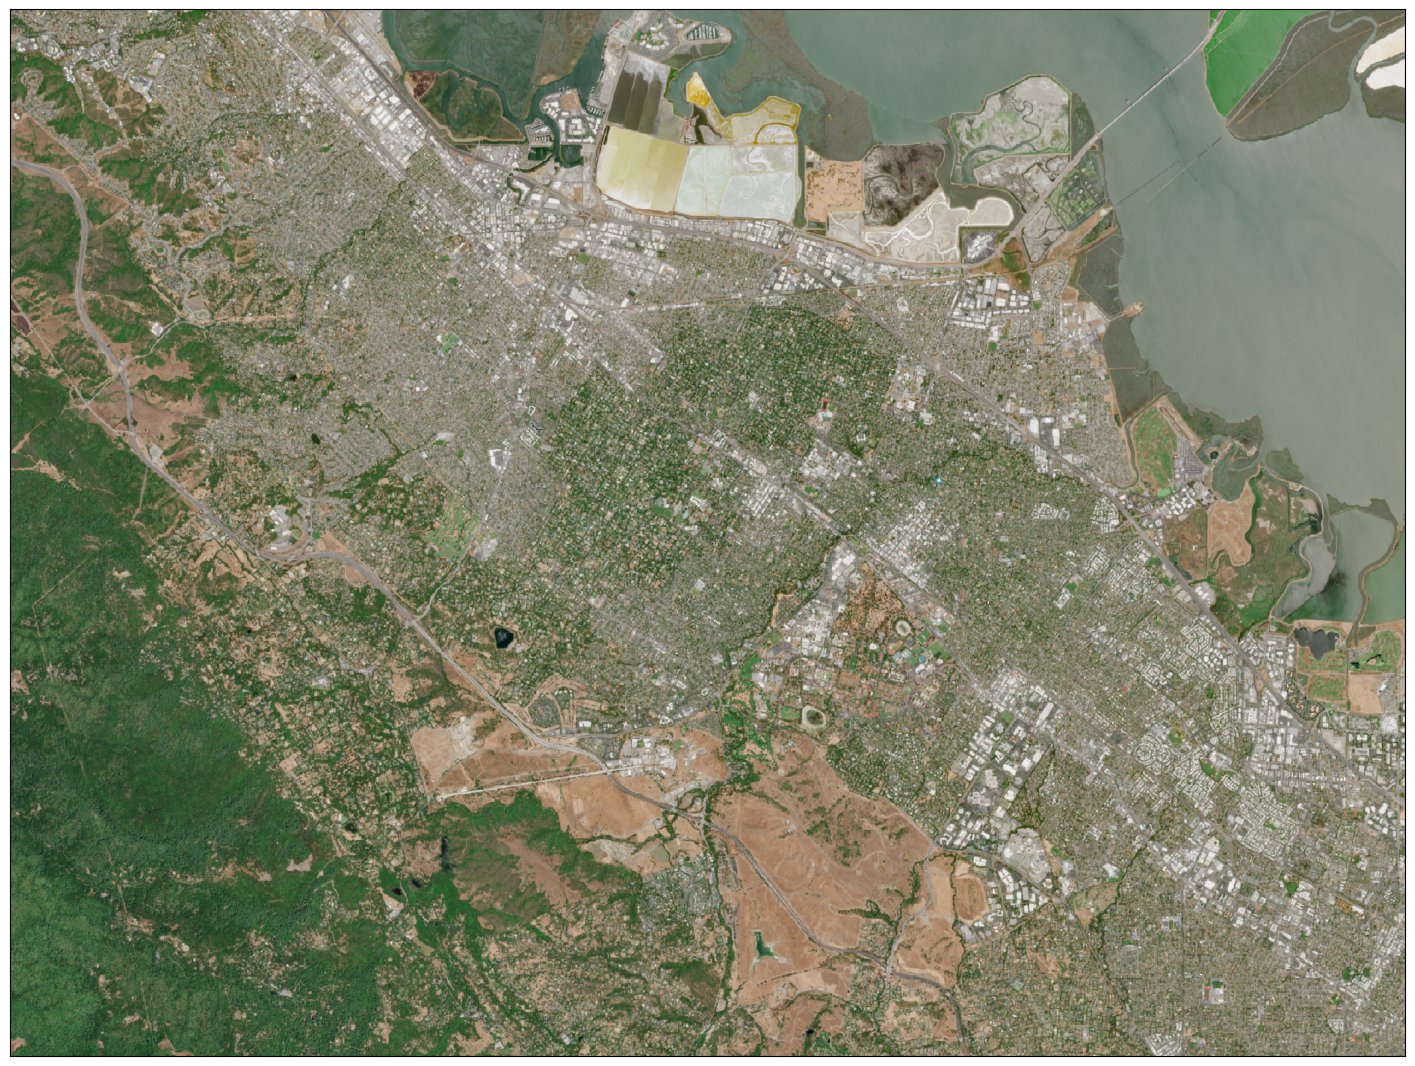

In [9]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=1 / 255, clip_range=(0, 1))
#image

#### Example 2: NDVI Image

Secondly, we will also show you an example of how to calculate and visualise NDVI using the same API. NDVI calculation is a very commonly used spectral vegetation index for vegetation monitoring, for example, monitoring crop growth and yields. As you will notice in the codeblock below, the evalscript has changed substantially:
- we are only using Band 4 and Band 8 as an input into our script.
- The `ColorGradientVisualizer` function has also been utilised in this script. More about this can be found in the documentation [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript/Functions.html#colorgradientvisualizer).

In [14]:
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [
        "B04",
        "B08"
    ],
    output: {
      bands: 3
    }
  }
}
  
let viz = ColorGradientVisualizer.createWhiteGreen(-1.0, 1.0);

function evaluatePixel(samples) {
    let val = (samples.B08 - samples.B04) / (samples.B08 + samples.B04);
    return viz.process(val);
}
"""

request_ndvi_img = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="http://192.168.1.101:8081"
            ),
            time_interval=("2023-07-01", "2023-07-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

The same method as before is used to request and then visualise the data. In the visualisation, the lighter greens indicate a higher NDVI value (vegetation, forest) and the darker greens (urban areas and water bodies) represent areas with lower NDVI values.

In [15]:
ndvi_img = request_ndvi_img.get_data()

In [16]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1542, 2055, 3)


Image type: uint8


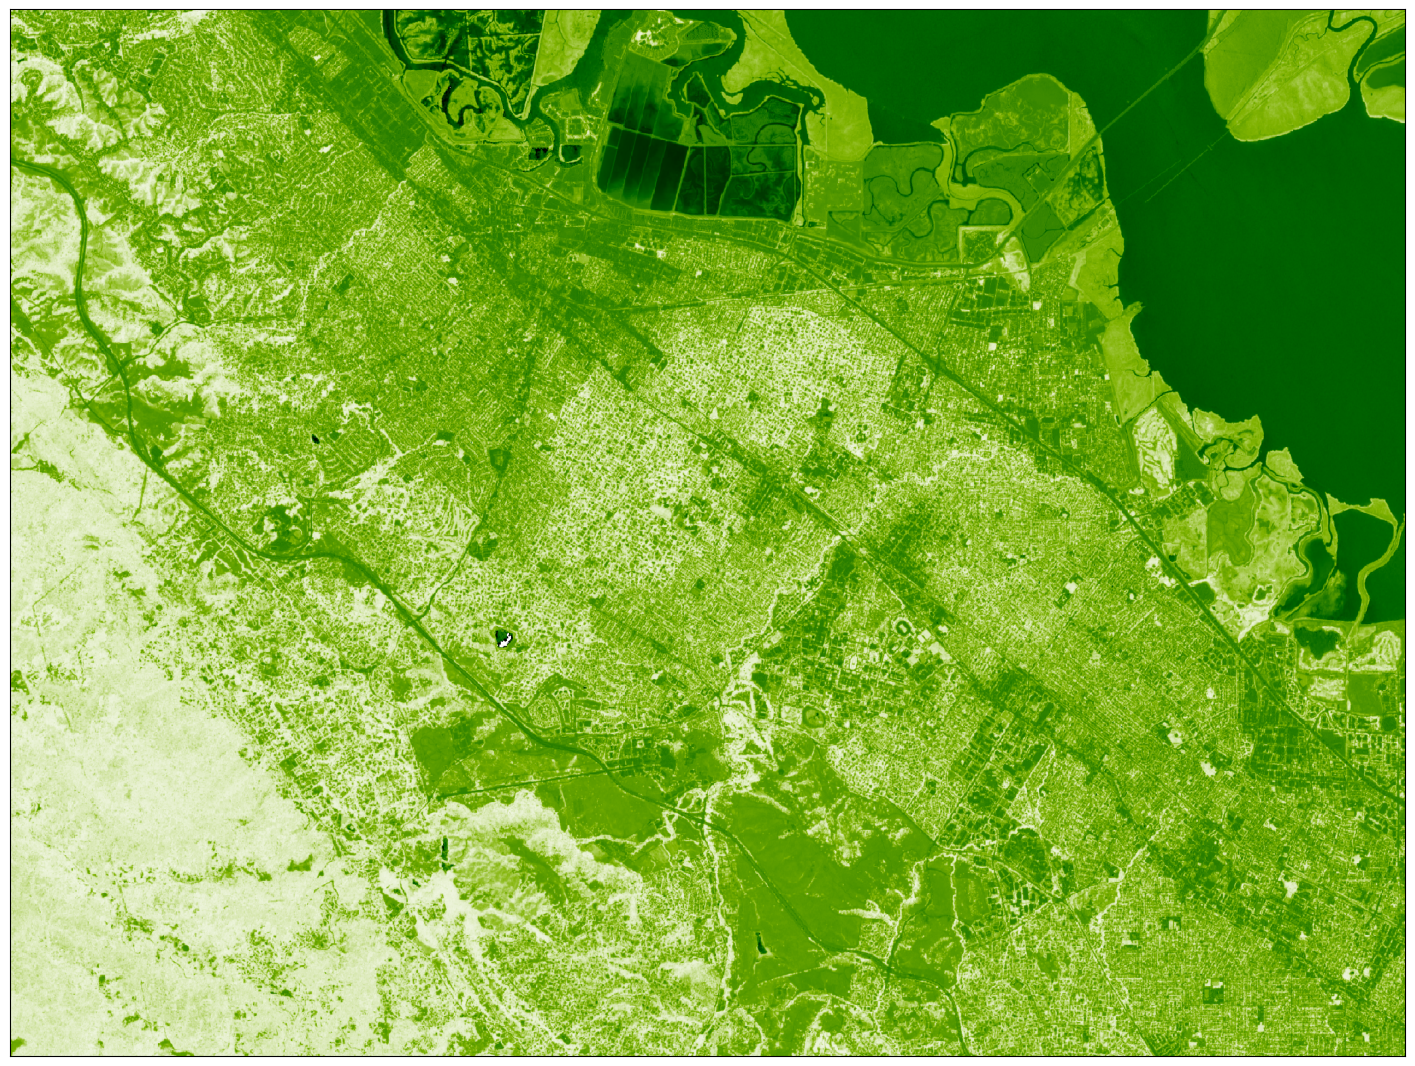

In [17]:
image = ndvi_img[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=1 / 255, clip_range=(-1, 1))